In [3]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

%matplotlib inline

In [4]:
# Some usefull functions we are gonna use

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [5]:
# loading data

# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

data = loadmat('ex3data1.mat')
x, y = data['X'], data['y'].ravel()

# Setting value of 0 to 0 rather than 10
y[ y == 10 ] = 0

m = y.size

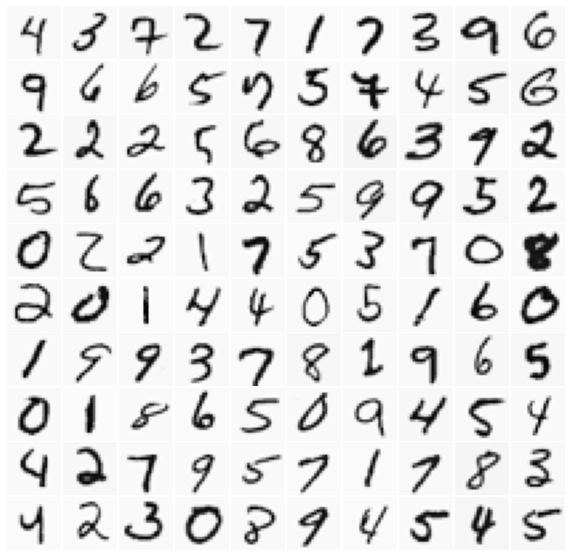

In [6]:
# Displaying data that we have loaded randomly
rand_indices = np.random.choice(m, 100, replace=False)
sel = x[rand_indices, :]

displayData(sel)

In [7]:
theta_test = np.array([-2, -1 , 1, 2], dtype=float)
x_test = np.append(np.ones(5).reshape(5,1), np.arange(1,16).reshape(5,3, order='F')/10, axis=1)
y_test = np.array([1,0,1,0,1])
lambda_test = 3

####  Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. The cost function of Logistic Regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

Your job is to write the unregularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

<div class="alert alert-box alert-warning">
**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</div>

Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now
add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

Now modify your code in lrCostFunction in the (#lrCostFunction) to account for regularization. Once again, you should not put any loops into your code.

<div class="alert alert-box alert-warning">
**python/numpy Tip:** When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In `numpy`, you can index into the matrices to access and update only certain elements. For example, A[:, 3:5]
= B[:, 1:3] will replaces the columns with index 3 to 5 of A with the columns with index 1 to 3 from B. To select columns (or rows) until the end of the matrix, you can leave the right hand side of the colon blank. For example, A[:, 2:] will only return elements from the $3^{rd}$ to last columns of $A$. If you leave the left hand size of the colon blank, you will select elements from the beginning of the matrix. For example, A[:, :2] selects the first two columns, and is equivalent to A[:, 0:2]. In addition, you can use negative indices to index arrays from the end. Thus, A[:, :-1] selects all columns of A except the last column, and A[:, -5:] selects the $5^{th}$ column from the end to the last column. Thus, you could use this together with the sum and power ($^{**}$) operations to compute the sum of only the elements you are interested in (e.g., `np.sum(z[1:]**2)`). In the starter code, `lrCostFunction`, we have also provided hints on yet another possible method computing the regularized gradient.
</div>

In [8]:
def lrCostFunction(theta, x, y, lambda_):
    
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    
    grad = np.zeros(theta.shape)
    
    #----------------Implementation----------------#
    
    h = sigmoid(np.dot(x,theta))
    j = (np.sum((-y * np.log(h)) - (1 - y) * np.log(1 - h)) / m) + (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
    
    grad = x.T @ (h - y) / m
    grad[1:] = grad[1:] + ((lambda_ * theta[1:]) /  m)
    
    #----------------/Implementation----------------#
    
    
    return j, grad

In [9]:
J,grad = lrCostFunction(theta_test, x_test, y_test, lambda_test)
print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


<h3>One-vs-all Classification</h3>

In this part of the exercise, we will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, you will want a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task. 

In [10]:
def oneVsAll(x, y, num_labels, lambda_):
    
    # Some useful variables
    m, n = x.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    x = np.concatenate([np.ones((m, 1)), x], axis=1)
    
    test_t = np.zeros((num_labels, n + 1))

    # ====================== YOUR CODE HERE ======================
    options = {'maxiter' : 50}
    
    initial_theta = np.zeros(n + 1)
    

    for i in range(num_labels):
        res = optimize.minimize(lrCostFunction, initial_theta, (x, (y == i), lambda_), jac=True, method='TNC', options=options)
        all_theta[i] = res.x

    

    # ============================================================
    return all_theta

In [20]:
lambda_ = 0.1
all_theta = oneVsAll(x, y, num_labels, lambda_)
print(all_theta)

[[-7.72465030e+00  0.00000000e+00  0.00000000e+00 ...  2.22821323e-04
   2.22473715e-05  0.00000000e+00]
 [-3.54565587e+00  0.00000000e+00  0.00000000e+00 ...  4.99189358e-03
   1.73650914e-07  0.00000000e+00]
 [-4.03097889e+00  0.00000000e+00  0.00000000e+00 ...  7.13527122e-03
  -8.21541211e-04  0.00000000e+00]
 ...
 [-2.69087960e+00  0.00000000e+00  0.00000000e+00 ... -7.70277519e-04
   9.77137435e-05  0.00000000e+00]
 [-8.76406097e+00  0.00000000e+00  0.00000000e+00 ... -1.41304560e-04
   1.10769597e-05  0.00000000e+00]
 [-5.45969076e+00  0.00000000e+00  0.00000000e+00 ... -3.07388611e-03
   2.35775378e-04  0.00000000e+00]]


In [24]:
def predictOneVsAll(all_theta, x):
    
    m = x.shape[0]
    
    num_label = all_theta.shape[0]
    
    prediction = np.zeros(m)
    
    x = np.concatenate([np.ones((m, 1)), x], axis=1)
    
    prediction = np.argmax(sigmoid(np.dot(x,all_theta.T)), axis= 1)
    
    return prediction


In [25]:
pred = predictOneVsAll(all_theta, x)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.38%
